In [14]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
torch.manual_seed(0)  # Set for testing purposes, please do not change!


In [15]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
n_samples = batch_size
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device:", torch.cuda.get_device_name(device))
else:
    device = torch.device("cpu")
    print("Using CPU device.")

Using CPU device.


In [16]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()


dataloader = DataLoader(
    MNIST(".", download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True,
)

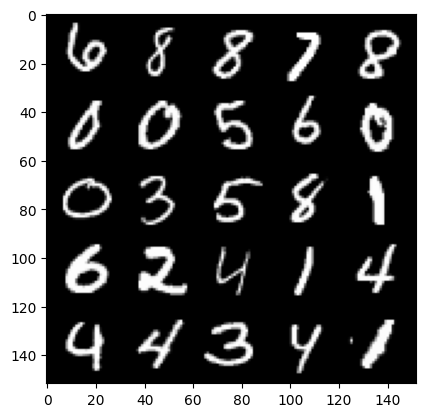

In [17]:
for data in dataloader:
    image, label = data
    break
show_tensor_images(image)


In [18]:
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
         nn.Linear(input_dim, output_dim), #Layer 1
         nn.LeakyReLU(0.2, inplace=True)
    )
class Generator(nn.Module):

    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        return self.gen(noise)
    
    def get_gen(self):
        return self.gen
class Discriminator(nn.Module):

    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        return self.disc(image)
    
    def get_disc(self):
        return self.disc

In [21]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()


gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        # image : 128, 1, 28, 28
        cur_batch_size = len(real)
        real_images = real.view(cur_batch_size, -1).to(device)
        # Train the discriminator 
        disc_opt.zero_grad()
        
        # Generate fake images and calculate fake loss of discriminator
        noise = torch.randn(n_samples, z_dim, device=device)
        fake_images = gen(noise)
        disc_fake_pred = disc(fake_images)

        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))

        # Use real images to calculate real loss of discriminator
        disc_real_pred = disc(real_images)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))

        disc_loss = disc_real_loss + disc_fake_loss
        disc_loss.backward()
        disc_opt.step()


        # Train the generator
        gen_opt.zero_grad()
        noise = torch.randn(n_samples, z_dim, device=device)
        fake_images = gen(noise)
        desc_fake_pred = disc(fake_images)

        gen_loss = criterion(desc_fake_pred, torch.ones_like(desc_fake_pred))

        gen_loss.backward()
        gen_opt.step()
 

        mean_discriminator_loss += disc_loss.item() / display_step

        mean_generator_loss += gen_loss.item() / display_step

        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = torch.randn(n_samples, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real_images)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1


 57%|█████▋    | 266/469 [00:07<00:05, 33.87it/s]